In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Identifying Quasars in the Sloan Digital Sky Survey

The [Sloan Digital Sky Survey](https://en.wikipedia.org/wiki/Sloan_Digital_Sky_Survey) was a major multi-spectral imaging survey that began in 2000, observing over 1 billion objects over ~35% of the sky.  Many (most) of these objects appear as point sources, leaving photometric (i.e., brightness) and spectroscopic (i.e., color) measurements as the only way to distinguish objects of different types.  Detailed spectra of objects can allow for robust classification, but is resource-intensive.  Gross spectral features (i.e., color) can be assessed using filters, which allow photometry over narrower bands of wavelenghs than the CCD is sensitive to.

The u, g, r, i, and z filters employed by SDSS:

<img src="https://www.sdss.org/wp-content/uploads/2014/11/camera_filters-300x274.jpg" style="width:800">

One astronomical objects SDSS proved useful in surveying is the quasar, an extremely active and luminous supermassive black hole in the center of a distant galaxy that's undergoing accretion.  As point sources, they are non-trivial to distinguish from other point sources in the survey, namely stars and white dwarfs in the Milky Way.  Confident classification can, and has, been done from spectral observations.  We'll use these confident spectroscopic classifications to train a logistic regression model to predict source classes based on the basic color information provided by SDSS's u, g, r, i, and z filters.

# Data

The data we'll be using is spread across three separate files, separated by spectroscopically confirmed classifications.

### Stars
First we'll pull data from spectroscopically confirmed stars:
```bash
!wget -q --no-check-certificate -O ../data/SDSS_stars.csv https://raw.githubusercontent.com/Astroinformatics/CAStArchive/refs/heads/main/MSMA/SDSS_stars.csv
```


This is a pretty standard csv file, which we can read in the usual way.

In [2]:
stars = pd.read_csv('../data/SDSS_stars.csv')
stars.head()

,u_mag,g_mag,r_mag,i_mag,z_mag,ra,dec
0,20.533161,17.968031,16.827314,16.373095,16.091063,190.001261,21.910620
1,18.894476,17.674576,17.208895,17.033516,16.972940,190.002330,21.874641
2,18.290901,17.022612,16.625498,16.431305,16.399673,190.012240,21.702999
3,19.784182,17.820679,17.003235,16.721306,16.541569,190.012912,23.667913
4,18.874607,17.638632,17.120625,16.907972,16.849592,190.012951,24.797507


We see magnitudes (recall, a logarithmic measure of brightness where larger means fainter;  thanks Hipparchus!) across the 5 filters employed by SDSS, as well as coordinates on the sky. Lets create a list of the names of the photometric measurements we'll be using for future use.

In [3]:
bands = ['u_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag']

### White dwarfs

White dwarfs are also in a CSV
```bash
!wget -q --no-check-certificate -O ../data/SDSS_wd.csv https://raw.githubusercontent.com/Astroinformatics/CAStArchive/refs/heads/main/MSMA/SDSS_wd.csv
```

Annoyingly there's a bunch of white space around the column names that pandas keeps.  The easiest way to get rid of this when reading in the file is to use a [regular](https://en.wikipedia.org/wiki/Regular_expression) [expression](https://regex101.com/r/AsD9jR/2) to specify a delimiter that's a comma surrounded by an abitrary amount of white space.

In [4]:
wds = pd.read_csv('../data/SDSS_wd.csv', sep='\s*[,]\s*', engine='python')
wds

,Sp_Class,u_mag,g_mag,r_mag,i_mag,z_mag,RA,Dec
0,DA_auto,19.186,18.835,18.884,19.052,19.407,0.028147,-0.781616
1,DA,19.421,19.565,20.000,20.277,21.152,0.029836,-9.727753
2,DQ,19.413,19.091,19.052,19.120,19.339,0.048182,-8.835651
3,DA_auto,20.423,20.041,19.925,20.030,20.012,0.051346,-0.845157
4,DA,19.285,18.891,18.810,18.886,18.958,0.093902,-10.861710
...,...,...,...,...,...,...,...,...
10085,DA,19.732,19.157,18.997,18.925,18.968,359.222057,0.360766
10086,DA,17.247,17.220,17.640,17.880,18.263,359.607505,-10.570337
10087,DA_CV:,19.427,19.708,20.165,20.545,20.841,359.674622,-1.004806
10088,DA_auto,19.973,19.520,19.635,19.739,19.757,359.905534,0.325716


Here we see the same photometric measurements, sky coordinates, as well as classification informations that we won't be needing.

### Quasars

Finally let's pull the spectroscopically confirmed Quasars.  More information on the data set can be found [here](https://sites.psu.edu/astrostatistics/datasets-sdss-quasar/).
```bash
!wget -q --no-check-certificate -O ../data/SDSS_QSO.dat https://raw.githubusercontent.com/Astroinformatics/CAStArchive/refs/heads/main/MSMA/SDSS_QSO.dat
```

In [5]:
inp = open('../data/SDSS_QSO.dat', 'r')
inp.readline()

'SDSS z u_mag sig_u_mag g_mag sig_g_mag r_mag sig_r_mag i_mag sig_i_mag z_mag sig_z_mag FIRST ROSAT Mp\n'

In [6]:
with open('../data/SDSS_QSO.dat', 'r') as inp:
    names = inp.readline().rstrip('\n').split(' ')
names

['SDSS',
 'z',
 'u_mag',
 'sig_u_mag',
 'g_mag',
 'sig_g_mag',
 'r_mag',
 'sig_r_mag',
 'i_mag',
 'sig_i_mag',
 'z_mag',
 'sig_z_mag',
 'FIRST',
 'ROSAT',
 'Mp']

We see that it's not comma-delimited, but instead what's called fixed-width. We can use `pd.read_fwf()` to handle this.

In [7]:
qsos = pd.read_fwf('../data/SDSS_QSO.dat', skiprows=1, header=None, names=names)
qsos.head()

,SDSS,z,u_mag,sig_u_mag,g_mag,sig_g_mag,r_mag,sig_r_mag,i_mag,sig_i_mag,z_mag,sig_z_mag,FIRST,ROSAT,Mp
0,000006.53+003055.2,1.8227,20.389,0.066,20.468,0.034,20.332,0.037,20.099,0.041,20.053,0.121,0.0,-9.0,-25.100
1,000008.13+001634.6,1.8365,20.233,0.054,20.200,0.024,19.945,0.032,19.491,0.032,19.191,0.068,0.0,-9.0,-25.738
2,000009.26+151754.5,1.1986,19.921,0.042,19.811,0.036,19.386,0.017,19.165,0.023,19.323,0.069,-1.0,-9.0,-25.085
3,000009.38+135618.4,2.2400,19.218,0.026,18.893,0.022,18.445,0.018,18.331,0.024,18.110,0.033,-1.0,-9.0,-27.419
4,000009.42-102751.9,1.8442,19.249,0.036,19.029,0.027,18.980,0.021,18.791,0.018,18.751,0.047,0.0,-9.0,-26.459


Here we have lots more info, including catalog IDs, uncertaines on photometric measurements, etc.

## Prepare Training Set

Now we'll prepare our training set.  The first thing we'll note is the number of each class of object we have.

In [8]:
len(stars), len(wds), len(qsos)

(5000, 10090, 77429)

It looks like the smallest set is the collection of stars.  To make our training set more uniform we'll select a subsets of the other objects to have an equal number of every class.

One thing that will cause trouble later if we don't deal with now is the presence of NaNs (not-a-number's).  The white dwarf data set contains some missing data.

In [9]:
wds.isna().any()

Sp_Class    False
u_mag        True
g_mag        True
r_mag        True
i_mag        True
z_mag        True
RA          False
Dec         False
dtype: bool

So when we select our subset of 5000 white dwards we'll make sure to avoid them.  Since we have white dwarfs to spare, lets also focus on the bright ones, to reduce the effects of potentially noisy observations of faint objects.  We'll do that by selecting only objects with a magnitude brighter (i.e., less) than 21 across all filters.

In [10]:
wd_sel = ~((np.any(wds[bands] > 21., axis=1)) | (np.any(np.isnan(wds[bands]), axis=1)))
print(np.count_nonzero(wd_sel))

9260


In [11]:
wds[wd_sel].isna().any()

Sp_Class    False
u_mag       False
g_mag       False
r_mag       False
i_mag       False
z_mag       False
RA          False
Dec         False
dtype: bool

With plenty left, we'll select 5000 random white dwarfs.

In [12]:
N = 5000
wds = wds[wd_sel].sample(N)
wds

,Sp_Class,u_mag,g_mag,r_mag,i_mag,z_mag,RA,Dec
2608,DZ,19.608,18.893,18.819,18.920,19.080,128.644474,46.691846
5358,DA_auto,18.741,18.273,18.297,18.352,18.571,170.831805,44.845989
4210,DA_auto,19.207,19.147,19.561,19.831,20.238,147.643064,56.460721
5939,DZ,18.906,18.225,18.140,18.260,18.440,186.889298,63.508217
4556,DA_auto,20.255,19.951,20.225,20.549,20.728,152.414529,6.365219
...,...,...,...,...,...,...,...,...
2395,DA_auto,20.267,19.807,19.770,19.802,19.814,125.783639,40.363466
9215,DA,20.331,19.936,20.145,20.331,20.636,262.513708,57.050460
1750,DA,18.487,18.320,18.605,18.881,19.160,117.822331,39.495117
5728,DA_auto,17.976,18.195,18.673,18.994,19.437,180.962656,63.257966


In [13]:
wds.isna().any()

Sp_Class    False
u_mag       False
g_mag       False
r_mag       False
i_mag       False
z_mag       False
RA          False
Dec         False
dtype: bool

Let's take the same approach to selecting a subset of quasars (it turns out there aren't any NaNs here).

In [14]:
qsos = qsos.sample(N)
qsos

,SDSS,z,u_mag,sig_u_mag,g_mag,sig_g_mag,r_mag,sig_r_mag,i_mag,sig_i_mag,z_mag,sig_z_mag,FIRST,ROSAT,Mp
37180,112630.54+554025.9,1.0812,18.426,0.024,18.290,0.018,18.075,0.013,18.083,0.016,18.128,0.028,0.0,-9.00,-25.853
71175,172220.36+292718.3,0.7695,20.735,0.060,19.914,0.017,19.428,0.019,19.395,0.019,18.825,0.034,0.0,-1.79,-23.761
43850,122009.14+680624.5,0.8654,19.146,0.025,18.835,0.016,18.676,0.019,18.758,0.017,18.621,0.037,-1.0,-9.00,-24.652
70701,171020.47+305905.6,0.6608,18.867,0.022,18.362,0.012,18.419,0.013,18.322,0.013,18.334,0.023,0.0,-9.00,-24.491
29924,102707.30+365801.8,1.8682,19.266,0.028,19.148,0.024,19.141,0.018,18.951,0.019,18.828,0.037,0.0,-9.00,-26.277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46744,124336.24+630000.3,1.0174,20.645,0.075,20.279,0.033,20.019,0.024,19.992,0.042,20.053,0.139,0.0,-9.00,-23.801
76700,234002.48+152645.4,1.3956,18.534,0.021,18.385,0.019,18.278,0.014,18.198,0.019,18.219,0.026,-1.0,-9.00,-26.391
24456,094438.30+562258.8,0.6445,20.637,0.066,20.418,0.030,20.369,0.027,20.070,0.034,19.987,0.113,0.0,-9.00,-22.612
53740,135619.90+591705.3,3.2950,21.321,0.115,19.461,0.024,19.045,0.014,18.931,0.018,18.853,0.052,0.0,-9.00,-27.578


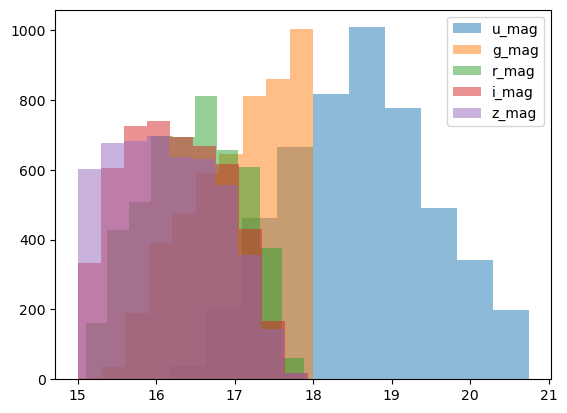

In [15]:
for band in bands:
    plt.hist(stars[band], label=band, alpha=0.5);
plt.legend();

It's important to remember, though, that these data live in a 5-D feature space.  We have the measured magnitude across 5 bands _for each object_.  We can get a better sense of the relationships between observed variables by looking at a pair, or corner, plot.

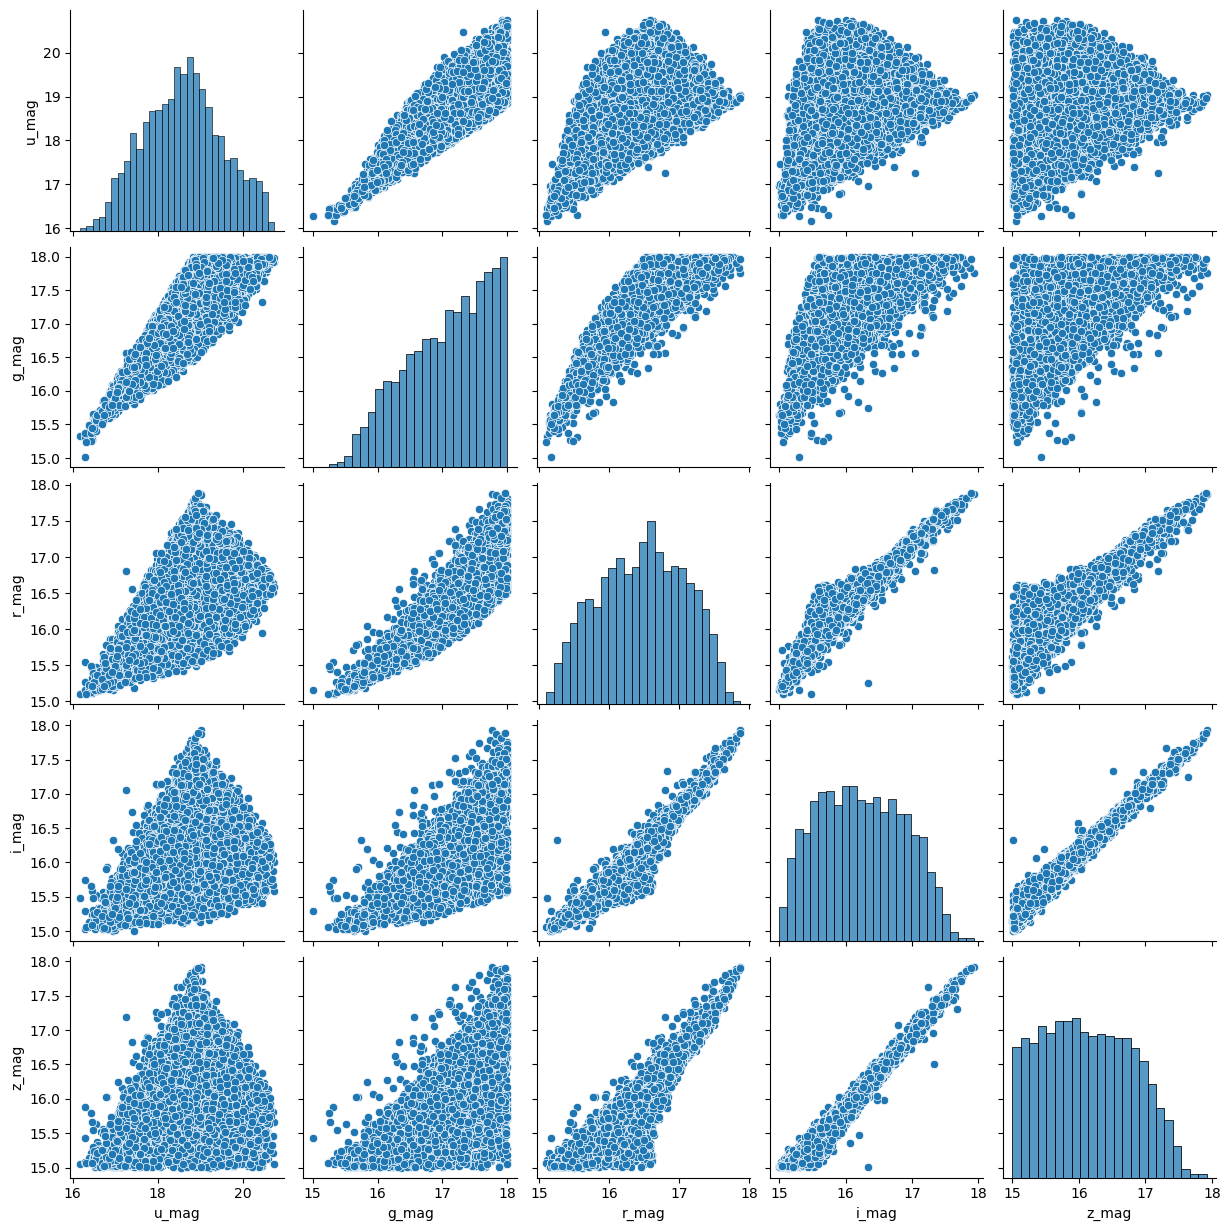

In [16]:
sns.pairplot(stars, vars=bands)

This figure shows scatter plots in the labeled pairs of dimensions in the off-diagonal spaces, and 1-D histograms of each variable along the diagonal.  Notice many of these magnitudes have strong linear correlations; this is due to a common (but unknown) factor between them: the distance to the source.  Since we won't want to rely on _knowing_ the distance to a source (necessary to determine the intrinsic, or absolute, brightness of the object) we can remove it's effects by taking the differences in magnitudes in different filters (remember they're logarithmic quantities!) to have quantitative measures of color.

We'll work with four color quantities.

In [17]:
colors = ['u-g', 'g-r', 'r-i', 'i-z']

We'll cycle through the dataframes we have and add columns containing these color quantities.

In [18]:
for cs in colors:
    c1, c2 = cs.split('-')
    for df in [stars, wds, qsos]:
        df[cs] = df[f'{c1}_mag'] - df[f'{c2}_mag']

Let's how the data look in color space.

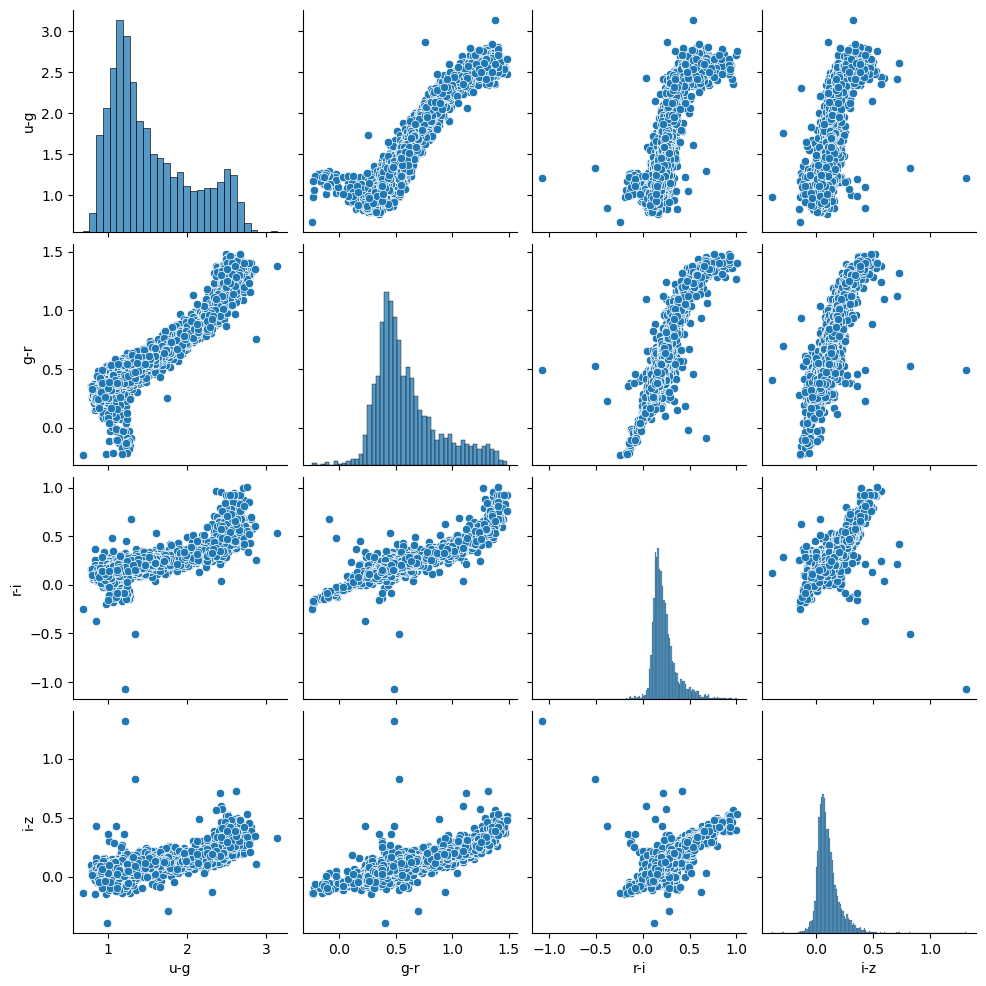

In [19]:
sns.pairplot(stars, vars=colors);

Much more interesting!

Finally, lets add a column to each dataframe containing object classes, concatenate the frames (only keeping the color quantities and classification), shuffle it, and write it to file.

In [20]:
stars['class'] = 'star'
wds['class'] = 'wd'
qsos['class'] = 'qso'

In [21]:
training = pd.concat([df[colors+['class']] for df in [stars, wds, qsos]])
training

,u-g,g-r,r-i,i-z,class
0,2.565130,1.140717,0.454219,0.282032,star
1,1.219900,0.465681,0.175379,0.060576,star
2,1.268289,0.397114,0.194193,0.031632,star
3,1.963503,0.817444,0.281929,0.179737,star
4,1.235975,0.518007,0.212653,0.058380,star
...,...,...,...,...,...
46744,0.366000,0.260000,0.027000,-0.061000,qso
76700,0.149000,0.107000,0.080000,-0.021000,qso
24456,0.219000,0.049000,0.299000,0.083000,qso
53740,1.860000,0.416000,0.114000,0.078000,qso


Let's separate a random 10% of the data for testing, then save these data to file.

In [22]:
training = training.sample(frac=1).reset_index(drop=True)   # shuffle and reset the counting index
testing = training.sample(frac=0.2)    # take 20% of the data for testing
training = training.drop(testing.index)  # drop the testing data from the training data

training.to_csv('../cache/SDSS_training.csv', index=False)  # write to file
testing.to_csv('../cache/SDSS_testing.csv', index=False)    # write to file

# Quasar classifier

Now let's finally get to building and training a quasar classifier.  For this we'll use a logistic regression model to isolate quasars.

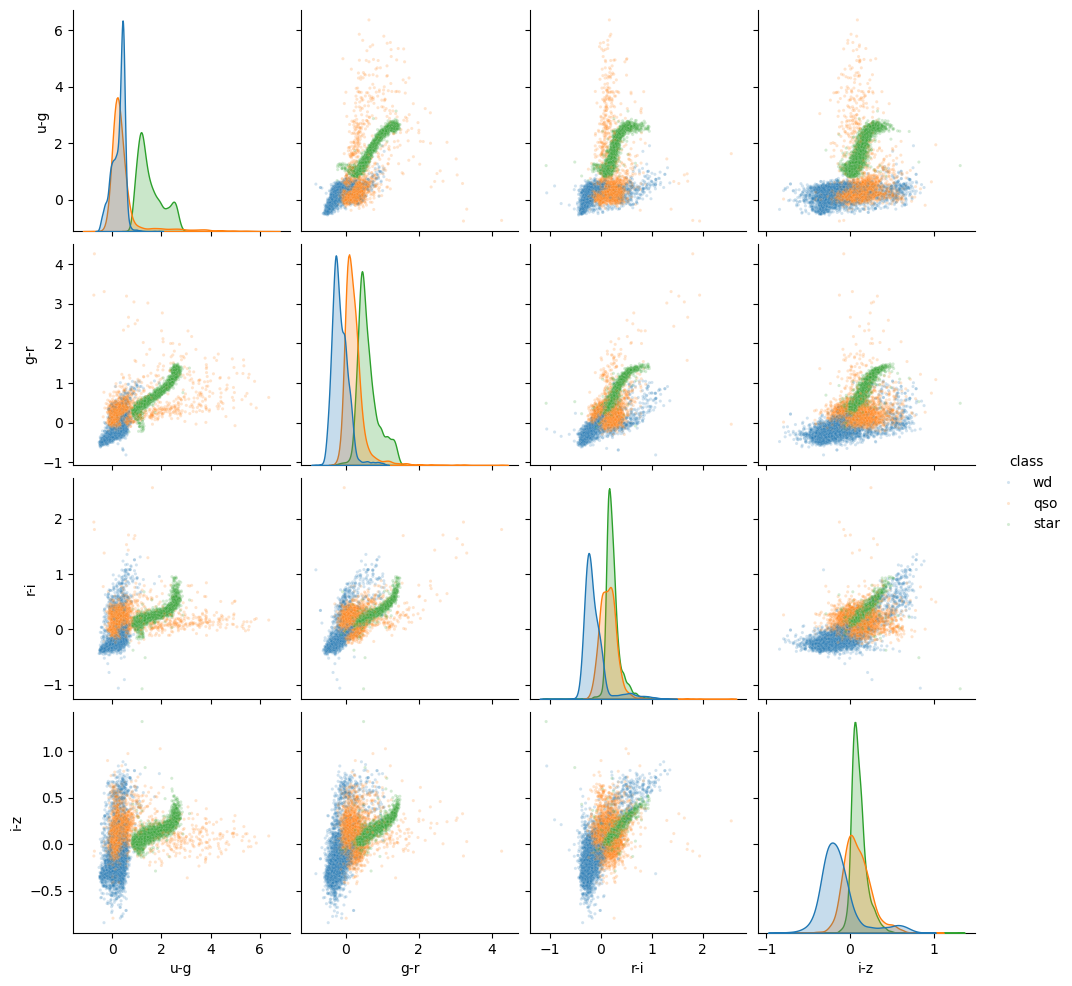

In [23]:
sns.pairplot(training, hue='class', plot_kws={'s':5, 'alpha': 0.2});